---
## Transfer Learning using Keras for cat vs dog classification problem
---
Author: Eugene Klyshko

Adapted from <a href="https://towardsdatascience.com/transfer-learning-and-image-classification-using-keras-on-kaggle-kernels-c76d3b030649"> here </a>, <a href="https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8"> here </a> and mostly <a href="https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html"> here </a>.

I used `Keras API 2.0`, TensorFlow backend, Nvidia GTX1080 gpu and python 3 notebook from Anaconda. 


The image classification requires massive amount of data for training to be able to achieve near or above human level accuracy. For example, `ImageNet` (http://www.image-net.org/) has 14 million images with 21 thousand classes. It's insanely large, and to train the model on this data set you have to spend lots of time (months) and use large computational resources ($$). 

However, some particular real world/production problems don't have such a big scale and only utilize small amount of data. For example:

- recognition of your pet (smart-lock with camera on your door)
- recognition of your face (camera on your iPhone)
- search for defects at the production line
- determination of the size of your lips (classify as big, small, medium)
- ***cats vs dogs classification***
- etc

Let's say we have only 6,000 images of cats and dogs. The best model you can build from scratch and train on this data set will give an accuracy of ~80%. 
Very long and tiring fine-tuning of hyperparameters - epochs, learning rates, input size, network depth and width, backprop algorithms etc - won't increase your accuracy above 90%.
It's not considered OK for our today's `AI-on-every-corner` world.


But alas! there is a way….

### Transfer learning walks in!
But then you ask, what is Transfer learning?

Well, TL (Transfer learning) is a popular training technique used in deep learning; where models that have been trained for a task are reused as base/starting point for another model. Some smart researchers built models, trained on large image datasets like ImageNet, COCO, Open Images, and decided to share their models to the general public for reuse.

This means you should never have to train an Image classifier from scratch again, unless you have a very, very large dataset different from the ones above or you want to be a hero.

### Why does transfer learning work?
Transfer learning works for Image classification problems because Neural Networks learn in an increasingly complex way. i.e the deeper you go down the network the more image specific features are learnt.


A neural network learns to detect objects in increasing level of complexity:
![pic1](pics/1.png)

Let’s build some intuition to understand this better. In a neural network trying to detect faces, we notice that the network learns to detect edges in the first layer, some basic shapes in the second and complex features as it goes deeper.

So the idea here is that all images have shapes and edges and we can only identify differences between them when we start extracting higher level features like-say nose in a face or tires in a car. Only then can we say, okay; this is a person, because it has a nose and this is an automobile because it has a tires.

The take-away here is that the earlier layers of a neural network will always detect the same basic shapes and edges that are present in both the picture of a car and a person.

Now, taking this intuition to our problem of differentiating dogs from cats, it means we can use models that have been trained on huge dataset containing different types of animals. This works because these models have learnt already the basic shape and structure of animals and therefore all we need to do, is teach it (model) the high level features of our new images.

![pic2](pics/2.jpg)

All I’m trying to say is that we need a network already trained on a large image dataset like `ImageNet`. Since this model already knows how classify different animals, then we can use this existing knowledge to quickly train a new classifier to identify our specific classes (cats and dogs).

### Choosing a pretrained NN

Now that we have an understanding/intuition of what Transfer Learning is, let’s talk about pretrained networks.

There are different variants of pretrained networks each with its own architecture, speed, size, advantages and disadvantages.

Keras comes prepackaged with many types of these pretrained models. Some of them are:

- **VGGNET**: Introduced by Simonyan and Zisserman in their 2014 paper, Very Deep Convolutional Networks for Large Scale Image Recognition.
- **RESNET**: First introduced by He et al. in their 2015 paper, Deep Residual Learning for Image Recognition
- **INCEPTION**: The “Inception” micro-architecture was first introduced by Szegedy et al. in their 2014 paper, Going Deeper with Convolutions:
- **XCEPTION**: Xception was proposed by François Chollet , the creator of the Keras library.
and many more.
![pic3](pics/3.png)

Detailed explanation of some of these architectures can be found here.

We’ll be using `VGG16` in this tutorial

![pic4](pics/4.png)


---
# Approach 1. ConvNet from scratch. 80% accuracy in 5 minutes
---

The Cats and Dogs data for the tutorial should look like this:
(downloadable at: https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip) 


`Dataset/
    train/
        Dog/
            1.jpg
            2.jpg
            ...
        Cat/
            1.jpg
            2.jpg
            ...
    val/
        Dog/
            1.jpg
            2.jpg
            ...
        Cat/
            1.jpg
            2.jpg
            ...
    test/
        1.jpg
        2.jpg
        ...     
`

### This is how Keras ImageDataGenerator works with processing of pictures

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('Dataset/train/Cat/1.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 281, 300)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 281, 300)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `temp/` directory - make sure you create it before running the script

i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='temp', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 0:
        break  # otherwise the generator would loop indefinitely

### Building our own small ConvNet

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import numpy as np

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = "Dataset/train"
validation_data_dir = "Dataset/val"
num_train = 5998
num_val = 1002

epochs = 10
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

########################

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
###################################
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [85]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_11 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)        18496     
__________

### The way to generate and standardize data from folder

In [86]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 5998 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


### Training the model... 10 epochs is about 5-6 minutes

In [87]:
model.fit_generator(train_generator, steps_per_epoch=num_train // batch_size, epochs=epochs,
                    validation_data=validation_generator, validation_steps=num_val // batch_size)

model.save_weights('first_try.h5')

Epoch 1/10
245/374 [==================>...........] - ETA: 8s - loss: 0.7073 - acc: 0.5327

/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


266/374 [====================>.........] - ETA: 6s - loss: 0.7036 - acc: 0.5392

/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlu

373/374 [============================>.] - ETA: 0s - loss: 0.6929 - acc: 0.5641

/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293863424 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffIma

374/374 [==============================] - 25s 67ms/step - loss: 0.6927 - acc: 0.5644 - val_loss: 0.6054 - val_acc: 0.6916
Epoch 2/10
374/374 [==============================] - 25s 67ms/step - loss: 0.6375 - acc: 0.6498 - val_loss: 0.5954 - val_acc: 0.6926
Epoch 3/10
374/374 [==============================] - 25s 67ms/step - loss: 0.6141 - acc: 0.6762 - val_loss: 0.5497 - val_acc: 0.7345
Epoch 4/10
374/374 [==============================] - 25s 67ms/step - loss: 0.5966 - acc: 0.6857 - val_loss: 0.5380 - val_acc: 0.7655
Epoch 5/10
374/374 [==============================] - 25s 67ms/step - loss: 0.5703 - acc: 0.7116 - val_loss: 0.4969 - val_acc: 0.7495
Epoch 6/10
374/374 [==============================] - 25s 66ms/step - loss: 0.5548 - acc: 0.7268 - val_loss: 0.5687 - val_acc: 0.7695
Epoch 7/10
374/374 [==============================] - 25s 66ms/step - loss: 0.5469 - acc: 0.7355 - val_loss: 0.4655 - val_acc: 0.7954
Epoch 8/10
374/374 [==============================] - 25s 66ms/step - los

### Getting 81% accuracy in 5 minutes of training. Not bad at all :)

In [8]:
model.save('convnet.h5')

In [1]:
from keras.models import load_model
model = load_model('convnet.h5')

/home/klyshko/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## The way to look at prediction by the model

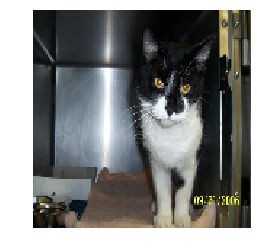

Dog


In [20]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import numpy as np

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

def predict_from_probability(p):
    classes = ['Cat', 'Dog']
    index = int(round(p))
    return classes[index]

# image path
img_path = 'Dataset/val/Dog/3333.jpg'    # dog
img_path = 'Dataset/val/Cat/3333.jpg'      # cat

# load a single image
new_image = load_image(img_path, True)

# check prediction
pred = model.predict(new_image)
print(predict_from_probability(pred[0][0]))

In [5]:
files = os.listdir('Dataset/test')
print(files[:10])

['6588.jpg', '6495.jpg', '6511.jpg', '6573.jpg', '6550.jpg', '6444.jpg', '648.jpg', '6564.jpg', '6401.jpg', '6432.jpg']


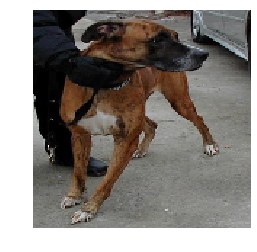

Dog [[0.9459452]]


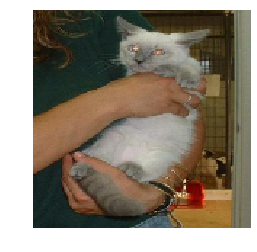

Cat [[0.4351737]]


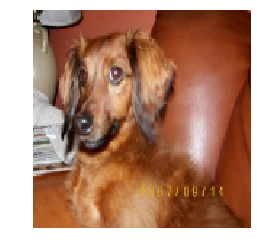

Cat [[0.47990698]]


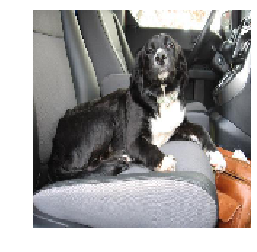

Cat [[0.41369134]]


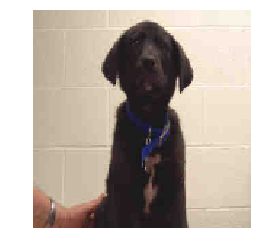

Dog [[0.921883]]


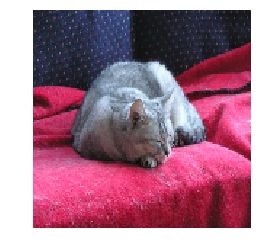

Cat [[0.39172167]]


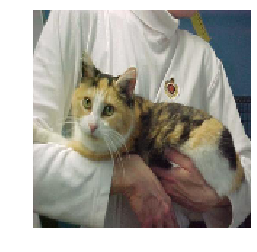

Cat [[0.38188922]]


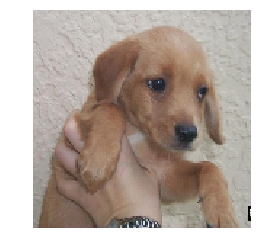

Dog [[0.5641852]]


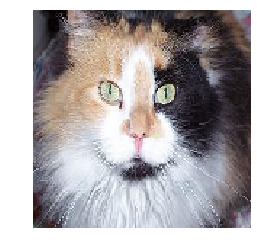

Cat [[0.41070232]]


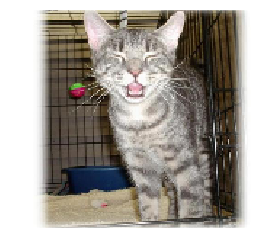

Cat [[0.1400374]]


In [6]:
for im in files[:10]:
    path = 'Dataset/test/' + im
    imag = load_image(path, True)
    pred = model.predict(imag)
    print(predict_from_probability(pred[0][0]), pred)

### We see 8/10 true classification! what output of the training has promised

---
# Approach 2. Using the bottleneck features of a pre-trained network VGG16: 90% accuracy in a minute
---

The architecture of `VGG16` network is represented here:
![pic5](pics/vgg16.png)

Our strategy will be as follow: we will only instantiate the convolutional part of the model, everything up to the fully-connected layers. We will then run this model on our training and validation data once, recording the output (the "bottleneck features" from th VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays. Then we will train a small fully-connected model on top of the stored features.

The reason why we are storing the features offline rather than adding our fully-connected model directly on top of a frozen convolutional base and running the whole thing, is computational effiency. Running VGG16 is expensive, especially if you're working on CPU, and we want to only do it once. Note that this prevents us from using data augmentation.

In [37]:
from keras import applications

top_model_weights_path = 'bottleneck_fc_model.h5'
epochs = 50
batch_size = 16

def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, num_train // batch_size)
    print(bottleneck_features_train.shape, bottleneck_features_train.dtype)
    np.save('bottleneck_features_train.npy',
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, num_val // batch_size)
    print(bottleneck_features_validation.shape, bottleneck_features_validation.dtype)
    np.save('bottleneck_features_validation.npy',
            bottleneck_features_validation)


def train_top_model():
    train_data = np.load('bottleneck_features_train.npy')
    validation_data = np.load('bottleneck_features_validation.npy')
    ## fixing the TIFFplugin warnings
    num_train_fixed = train_data.shape[0]
    num_val_fixed = validation_data.shape[0]
    
    train_labels = np.array(
        [0] * int((num_train_fixed / 2)) + [1] * int((num_train_fixed / 2)))
        
    validation_labels = np.array(
        [0] * int((num_val_fixed / 2)) + [1] * int((num_val_fixed / 2)))
    
    '''
     train_labels = np.array(
        [0] * (num_train / 2) + [1] * (num_train / 2))
        
    validation_labels = np.array(
        [0] * (num_val / 2) + [1] * (num_val / 2))

    '''
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)
    
    return model

In [33]:
save_bottlebeck_features()

Found 5998 images belonging to 2 classes.


/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlu

(5984, 4, 4, 512) float32
Found 1002 images belonging to 2 classes.


/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


(992, 4, 4, 512) float32


In [38]:
better_model = train_top_model()

Train on 5984 samples, validate on 992 samples
Epoch 1/50
5984/5984 [==============================] - 1s 184us/step - loss: 0.4648 - acc: 0.8150 - val_loss: 0.2893 - val_acc: 0.8770
Epoch 2/50
5984/5984 [==============================] - 1s 146us/step - loss: 0.3007 - acc: 0.8762 - val_loss: 0.4502 - val_acc: 0.8548
Epoch 3/50
5984/5984 [==============================] - 1s 146us/step - loss: 0.2830 - acc: 0.8924 - val_loss: 0.2272 - val_acc: 0.9073
Epoch 4/50
5984/5984 [==============================] - 1s 146us/step - loss: 0.2368 - acc: 0.9101 - val_loss: 0.2711 - val_acc: 0.9083
Epoch 5/50
5984/5984 [==============================] - 1s 146us/step - loss: 0.2348 - acc: 0.9098 - val_loss: 0.3240 - val_acc: 0.8962
Epoch 6/50
5984/5984 [==============================] - 1s 146us/step - loss: 0.2167 - acc: 0.9148 - val_loss: 0.2598 - val_acc: 0.9032
Epoch 7/50
5984/5984 [==============================] - 1s 146us/step - loss: 0.1952 - acc: 0.9275 - val_loss: 0.3012 - val_acc: 0.9042
E

### We reach a validation accuracy of 0.90!
Not bad at all. This is definitely partly due to the fact that the base model was trained on a dataset that already featured dogs and cats (among hundreds of other classes).

---
# Approach 3. Fine-tuning the top layers of a pre-trained network VGG16: 0.96 in 30 minutes
---
To further improve our previous result, we can try to "fine-tune" the last convolutional block of the VGG16 model alongside the top-level classifier. Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates. In our case, this can be done in 3 steps:

- instantiate the convolutional base of VGG16 and load its weights
- add our previously defined fully-connected model on top, and load its weights
- freeze the layers of the VGG16 model up to the last convolutional block

![pic6](pics/vgg16_modified.png)

In [53]:
from keras import Model
from keras import optimizers
# build the VGG16 network
vgg16_base = applications.VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
print('Model loaded.')

# build a classifier model to put on top of the convolutional base
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16_base.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
full_model = Model(inputs=vgg16_base.input, outputs= top_model(vgg16_base.output))

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in full_model.layers[:15]:
    layer.trainable = False

full_model.summary()
    
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
full_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0      

## Seeting up data generators again:

In [54]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 5998 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


## Training the model  for 25 minutes

In [55]:
# fine-tune the model
full_model.fit_generator(
    train_generator,
    samples_per_epoch=num_train,
    epochs=epochs,
    validation_data=validation_generator,
    nb_val_samples=num_val)

/home/klyshko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/home/klyshko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=50, validation_data=<keras_pre..., steps_per_epoch=374, validation_steps=1002)`
  import sys


Epoch 1/50
220/374 [================>.............] - ETA: 9s - loss: 0.4903 - acc: 0.7769 

/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlu

261/374 [===================>..........] - ETA: 7s - loss: 0.4760 - acc: 0.7868

/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


286/374 [=====================>........] - ETA: 5s - loss: 0.4656 - acc: 0.7924

/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293863424 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffIma

373/374 [============================>.] - ETA: 0s - loss: 0.4366 - acc: 0.8064

/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/klyshko/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


374/374 [==============================] - 26s 71ms/step - loss: 0.4359 - acc: 0.8070 - val_loss: 0.2238 - val_acc: 0.9092
Epoch 2/50
374/374 [==============================] - 26s 69ms/step - loss: 0.2564 - acc: 0.9054 - val_loss: 0.2127 - val_acc: 0.9212
Epoch 3/50
374/374 [==============================] - 26s 70ms/step - loss: 0.2075 - acc: 0.9163 - val_loss: 0.2203 - val_acc: 0.9232
Epoch 4/50
374/374 [==============================] - 26s 70ms/step - loss: 0.1783 - acc: 0.9340 - val_loss: 0.1794 - val_acc: 0.9202
Epoch 5/50
374/374 [==============================] - 26s 70ms/step - loss: 0.1472 - acc: 0.9449 - val_loss: 0.2037 - val_acc: 0.9361
Epoch 6/50
374/374 [==============================] - 26s 70ms/step - loss: 0.1400 - acc: 0.9505 - val_loss: 0.1787 - val_acc: 0.9311
Epoch 7/50
374/374 [==============================] - 26s 70ms/step - loss: 0.1192 - acc: 0.9549 - val_loss: 0.1803 - val_acc: 0.9421
Epoch 8/50
374/374 [==============================] - 26s 69ms/step - los

## Great! Accuracy: 0.96 

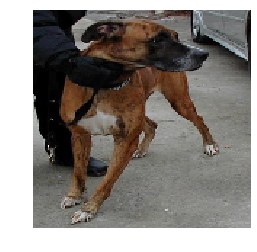

Dog [[1.]]


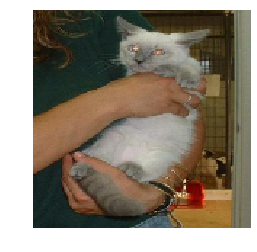

Cat [[0.04858904]]


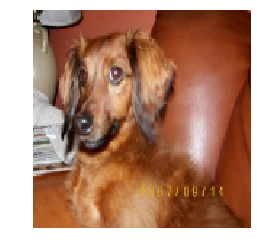

Dog [[1.]]


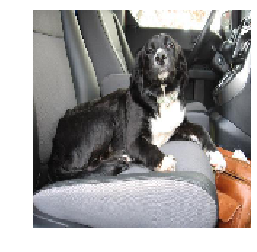

Dog [[0.6977658]]


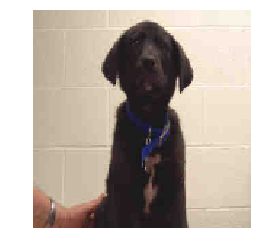

Dog [[1.]]


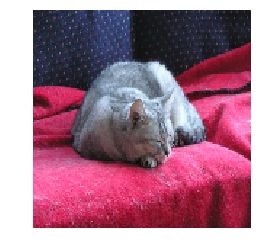

Cat [[5.1760147e-05]]


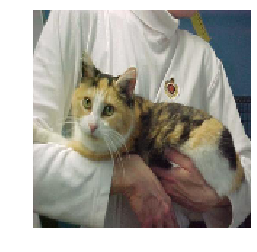

Cat [[1.7512629e-07]]


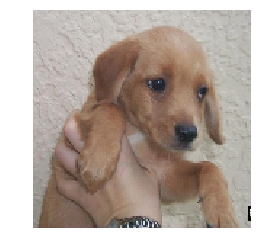

Dog [[1.]]


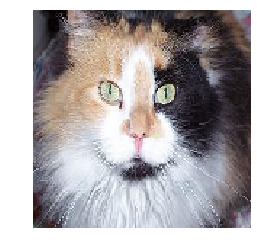

Cat [[6.1910385e-19]]


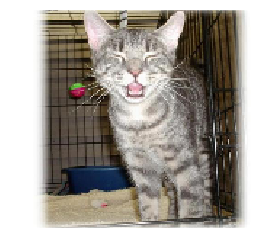

Cat [[5.5788613e-11]]


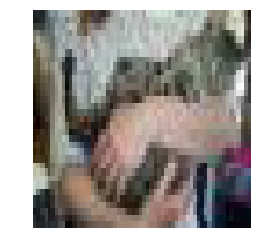

Dog [[0.9353642]]


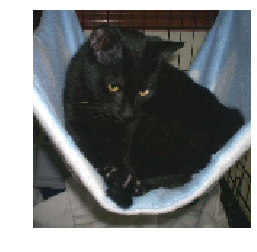

Cat [[0.00014781]]


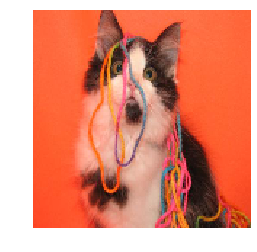

Dog [[1.]]


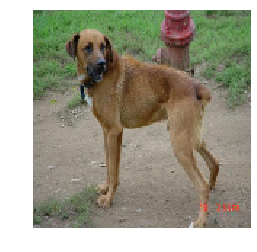

Dog [[1.]]


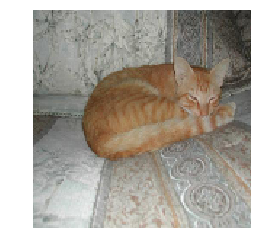

Cat [[0.00904887]]


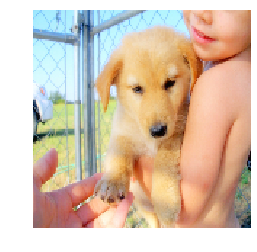

Dog [[1.]]


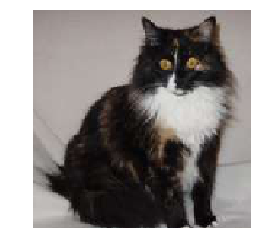

Cat [[9.70981e-10]]


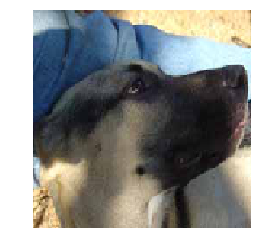

Dog [[0.99999285]]


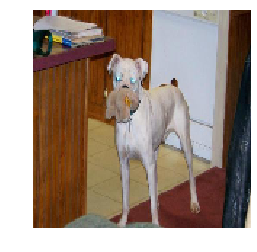

Dog [[1.]]


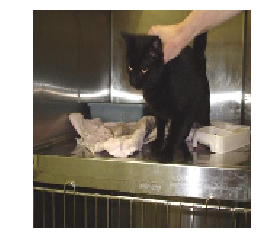

Cat [[0.04508829]]


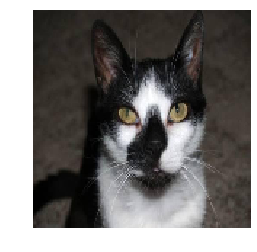

Cat [[1.4232857e-19]]


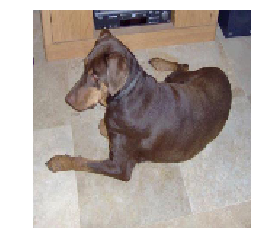

Dog [[1.]]


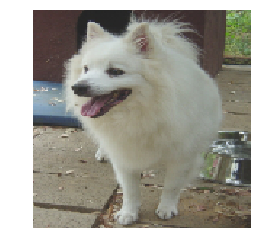

Dog [[1.]]


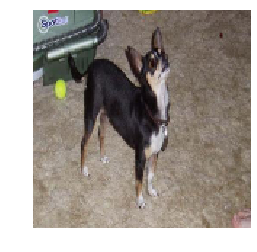

Dog [[1.]]


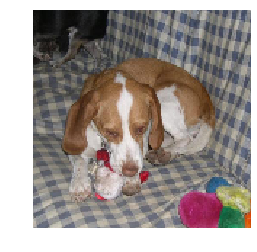

Dog [[0.999171]]


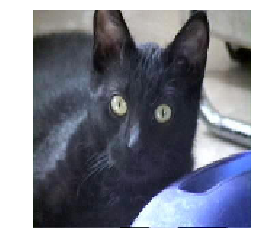

Cat [[2.8308947e-10]]


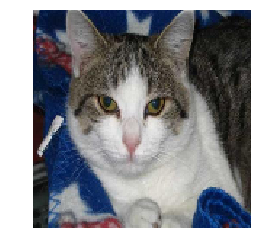

Cat [[3.2891682e-17]]


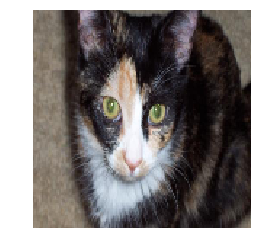

Cat [[9.060235e-16]]


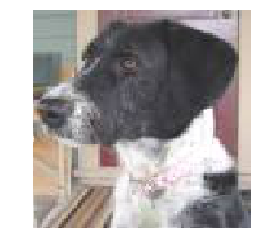

Dog [[0.99999917]]


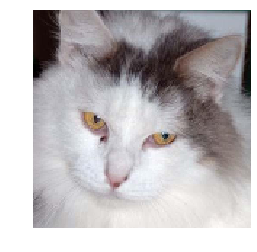

Cat [[2.8611736e-14]]


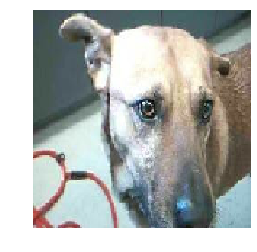

Dog [[1.]]


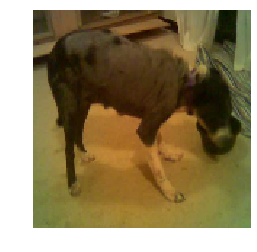

Dog [[1.]]


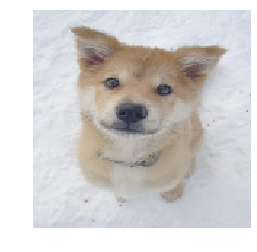

Dog [[1.]]


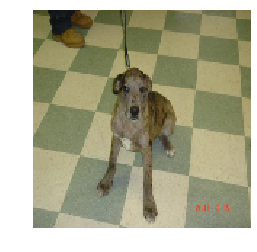

Dog [[1.]]


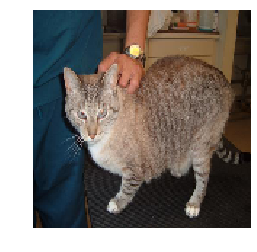

Cat [[7.107345e-10]]


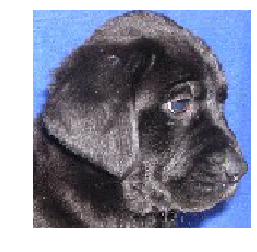

Dog [[1.]]


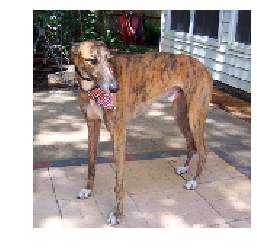

Dog [[1.]]


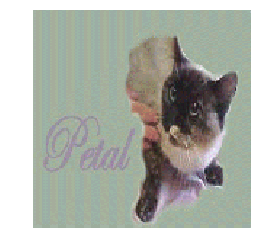

Cat [[0.00021938]]


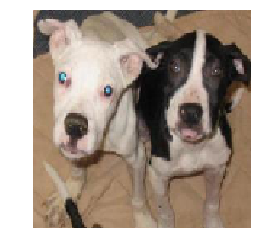

Dog [[1.]]


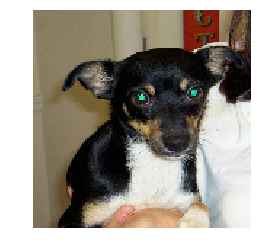

Dog [[1.]]


In [57]:
full_model.save('vgg16_fullmodel.h5')

for im in files[:40]:
    path = 'Dataset/test/' + im
    imag = load_image(path, True)
    pred = full_model.predict(imag)
    print(predict_from_probability(pred[0][0]), pred)

### We classified 39/40 animals. Unbelivable. 11th example is misclassified:

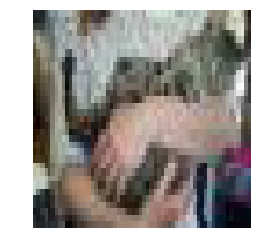

Dog [[0.9353642]]


In [59]:
for im in files[10:11]:
    path = 'Dataset/test/' + im
    imag = load_image(path, True)
    pred = full_model.predict(imag)
    print(predict_from_probability(pred[0][0]), pred)

And it's not a surprise. Not many people would guess what it (low resolution image) actually is.